El conjunto de datos contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos y fue obtenida de https://www.kaggle.com/datasets/whenamancodes/fraud-detection/data.

Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos está muy desequilibrado: la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Contiene sólo variables de entrada numéricas que son el resultado de una transformación PCA,debido a cuestiones de confidencialidad. Las características V1, V2,… V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Time' y 'Amount'. La columna 'Time' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La característica 'Amount' es el monto de la transacción. La columna 'Class' es la variable a predecir y toma el valor 1 en caso de fraude y 0 en caso contrario.

Dada la relación de desequilibrio de clases, se debe medir la precisión utilizando el Área Bajo la Curva de Precisión-Recall (AUPRC). La precisión de la matriz de confusión no es significativa para una clasificación desequilibrada.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve, make_scorer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from bayes_opt import BayesianOptimization
from xgboost import plot_importance
import scipy.stats as stats
from scipy.stats import uniform, randint, loguniform
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tqdm import tqdm
import optuna
import warnings

plt.style.use('ggplot')
warnings.filterwarnings("ignore", category=Warning, module='joblib')

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

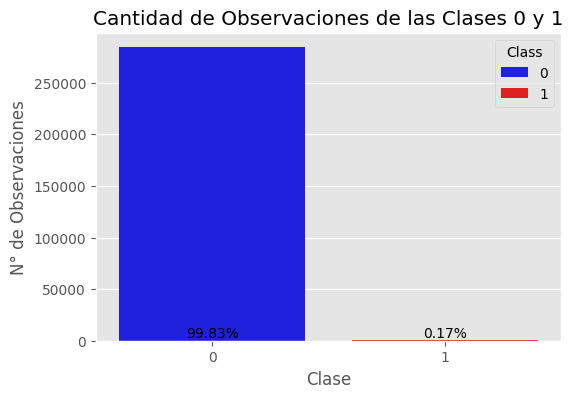

In [6]:
# Calcular el porcentaje de cada clase
class_counts = data['Class'].value_counts(normalize=True) * 100

# Definir colores para cada clase
colors = ['blue', 'red']

# Plotear la cantidad de observaciones de las clases 0 y 1
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data, hue='Class', palette=colors)
plt.title('Cantidad de Observaciones de las Clases 0 y 1')
plt.xlabel('Clase')
plt.ylabel('N° de Observaciones')

# Mostrar el texto de los porcentajes
for i in range(len(class_counts)):
    plt.text(i, class_counts[i], f'{class_counts[i]:.2f}%', ha='center', va='bottom')

plt.show()

Se observa que la clase 0 tiene una cantidad mucho mayor de observaciones que la clase 1, lo que indica que el conjunto de datos está muy desequilibrado y que las transacciones fraudulentas son muy escasas en comparación con las legítimas.

La clase 0 tiene 284,315 observaciones, lo que representa el 99.83% de todas las transacciones. Esto significa que casi todas las transacciones son legítimas y que el fraude es un fenómeno muy poco frecuente.

La clase 1 tiene 492 observaciones, lo que representa el 0.17% de todas las transacciones. Esto significa que solo hay 492 transacciones fraudulentas en el conjunto de datos, lo que supone un gran reto para detectarlas y prevenirlas.

Este gráfico nos permite visualizar la distribución de las clases en el conjunto de datos y el grado de desbalanceo que existe entre ellas.

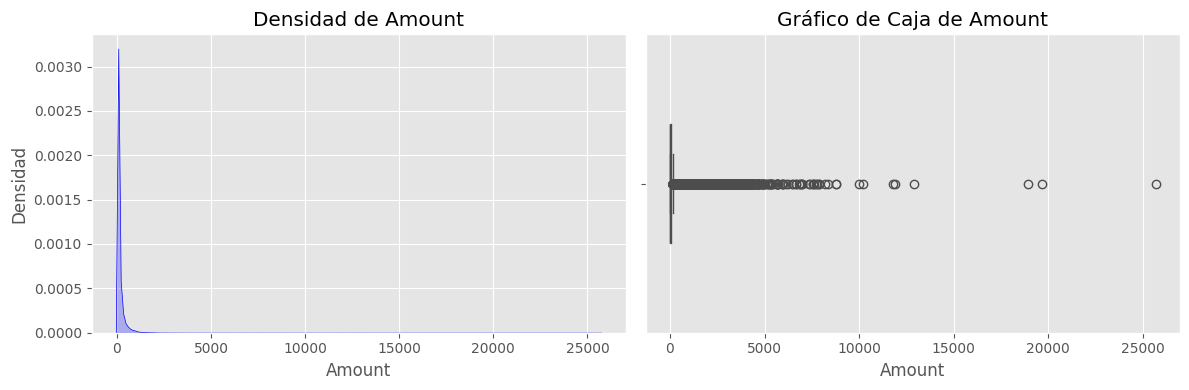

In [7]:
# Crear una figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plotear la densidad de la variable 'Amount' en el subplot izquierdo
sns.kdeplot(data=data, x='Amount', ax=axes[0], color='blue', fill=True)
axes[0].set_title('Densidad de Amount')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Densidad')

# Plotear un gráfico de caja de la variable 'Amount' en el subplot derecho
sns.boxplot(data=data, x='Amount', ax=axes[1], color='orange', width=0.4)
axes[1].set_title('Gráfico de Caja de Amount')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

La gráfica de densidad muestra la frecuencia relativa de los valores de la variable Amount, es decir, qué tan comunes son los diferentes montos de las transacciones. Se observa que la mayoría de los valores se concentran en el extremo izquierdo del gráfico, lo que indica que la mayoría de las transacciones tienen montos muy bajos. La curva tiene una forma asimétrica, con una cola larga hacia la derecha, lo que indica que hay algunos valores muy altos que se alejan del promedio. Estos valores pueden ser considerados como atípicos o anomalías.

En el gráfico de caja se observa que la mediana es muy baja, lo que confirma que la mayoría de las transacciones tienen montos pequeños. La caja es muy estrecha, lo que indica que hay poca variabilidad entre los valores centrales de los datos. Los bigotes son muy largos, lo que indica que hay mucha variabilidad entre los valores extremos de los datos. Hay muchos valores atípicos, lo que indica que hay algunas transacciones con montos muy altos que pueden ser sospechosas de fraude.

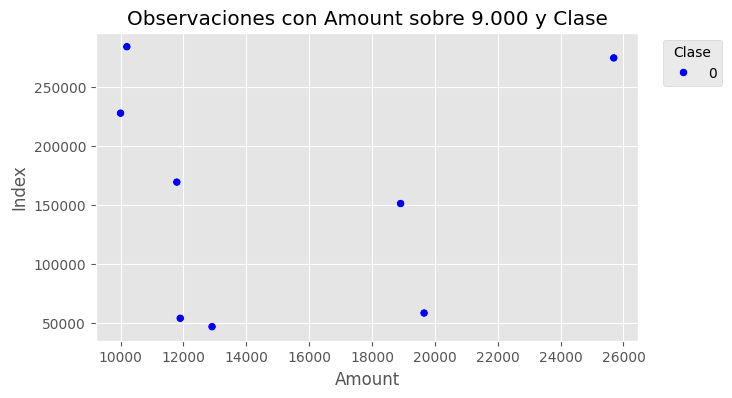

In [8]:
# Filtrar las observaciones con Amount sobre 9000
max_amount = data[data['Amount'] > 9000]

# Definir los colores para cada clase
colors = {0: 'blue', 1: 'red'}

# Plotear el gráfico de dispersión con colores personalizados
plt.figure(figsize=(7, 4))
scatterplot = sns.scatterplot(x='Amount', y=max_amount.index, hue='Class', data=max_amount, palette=colors)
plt.title('Observaciones con Amount sobre 9.000 y Clase')
plt.xlabel('Amount')
plt.ylabel('Index')

# Colocar la leyenda en el centro de la parte superior
plt.legend(title='Clase', bbox_to_anchor=(1.1, 1.0), loc='upper center')

plt.show()

Todas las observaciones de mayor monto de transacción son No Fraudulentas. En primera instancia no se eliminarán outliers.

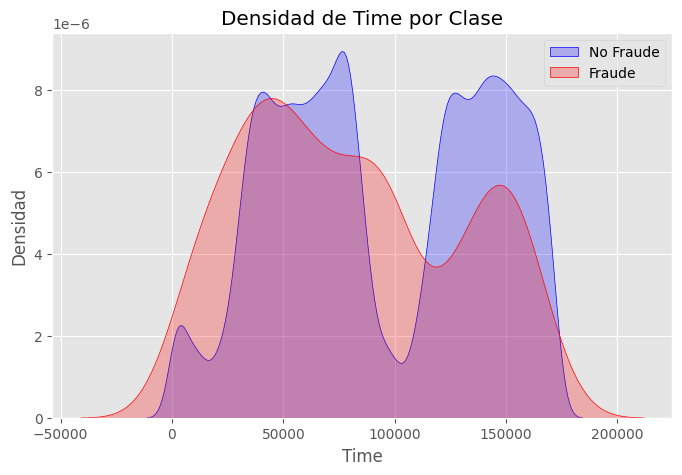

In [9]:
# Plotear la densidad de 'Time' separando por las clases 'No Fraude' (0) y 'Fraude' (1)
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['Class'] == 0]['Time'], color='blue', label='No Fraude', fill=True)
sns.kdeplot(data=data[data['Class'] == 1]['Time'], color='red', label='Fraude', fill=True)
plt.title('Densidad de Time por Clase')
plt.xlabel('Time')
plt.ylabel('Densidad')
plt.legend()
plt.show()

La variable ‘Time’ contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. Esto significa que el gráfico muestra cómo varía la frecuencia de las transacciones a lo largo del tiempo, según sean fraudulentas o no. Se puede ver que hay algunos momentos del tiempo donde la densidad de ambas clases es mayor, lo que implica que hay más transacciones en esos momentos. Estos momentos pueden corresponder a horas pico o períodos de alta actividad comercial. Sin embargo, no se aprecia una diferencia clara entre las clases en esos momentos, lo que sugiere que el fraude no depende del tiempo de la transacción.

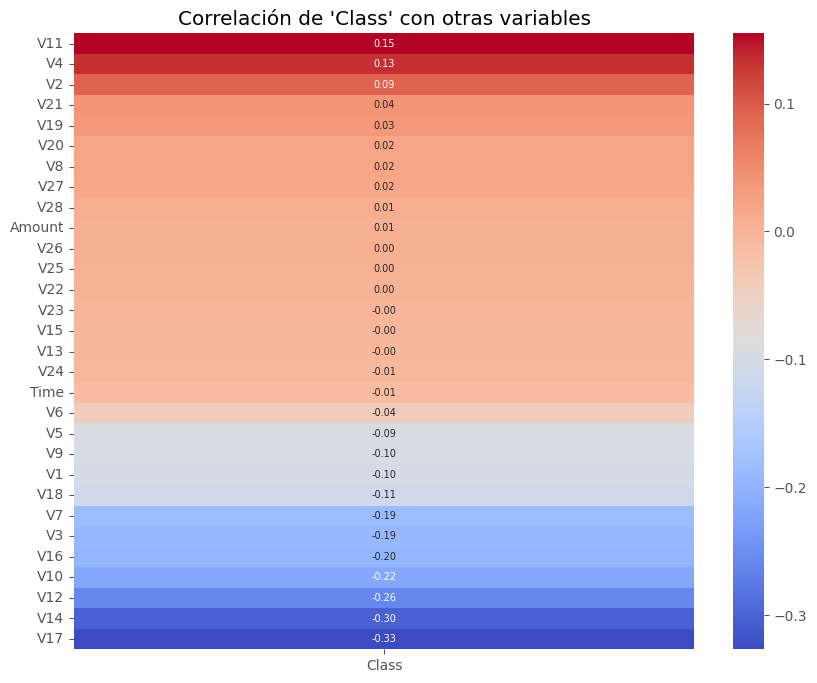

In [10]:
# Calcular la matriz de correlación
correlation_matrix = data.corr()

# Filtrar la correlación de 'Class' con otras variables
class_correlation_subset = correlation_matrix['Class'].drop('Class')

# Ordenar las variables por su correlación
class_correlation_subset_sorted = class_correlation_subset.sort_values(ascending=False)

# Plotear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(class_correlation_subset_sorted.to_frame(), cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 7})
plt.title("Correlación de 'Class' con otras variables")
plt.show()

Mediante la gráfica anterior se pueden identificar las variables que más ayuden a predecir transacciones fraudulentas, seleccionando las que tienen una correlación absoluta más alta con la variable objetivo 'Class' (fraude). En este caso, las variables con una correlación absoluta más alta son aquellas con valores más cercanos a 1 o -1, independientemente de si la correlación es positiva o negativa.

Basándonos en las correlaciones, las variables con mayor correlación absoluta son:

V14: -0.302544, V17: -0.326481, V12: -0.260593, V10: -0.216883 y V16: -0.196539.

Estas variables tienen correlaciones negativas relativamente altas con 'Class', lo que significa que a medida que aumentan, es menos probable que la transacción sea fraudulenta.

Por otro lado, las variables con correlaciones positivas relativamente altas son:

V4: 0.133447 y V11: 0.154876.

Aunque estas correlaciones son menores en comparación con las correlaciones negativas, aún podrían ser útiles en el modelo predictivo.

Por lo tanto, una estrategia adecuada podría ser seleccionar estas variables (V14, V17, V12, V10, V16, V4, V11) como características para el modelo de detección de fraudes, ya que tienen las correlaciones más altas (positivas o negativas) con la variable 'Class' y, por lo tanto, son las que más pueden ayudar a predecir transacciones fraudulentas.

In [11]:
# Seleccionar las variables relevantes junto con la variable 'Class'
relevant_variables = ['V14', 'V17', 'V12', 'V10', 'V16', 'V4', 'V11', 'Class']

# Filtrar el DataFrame para incluir solo las variables relevantes
filtered_data = data[relevant_variables]

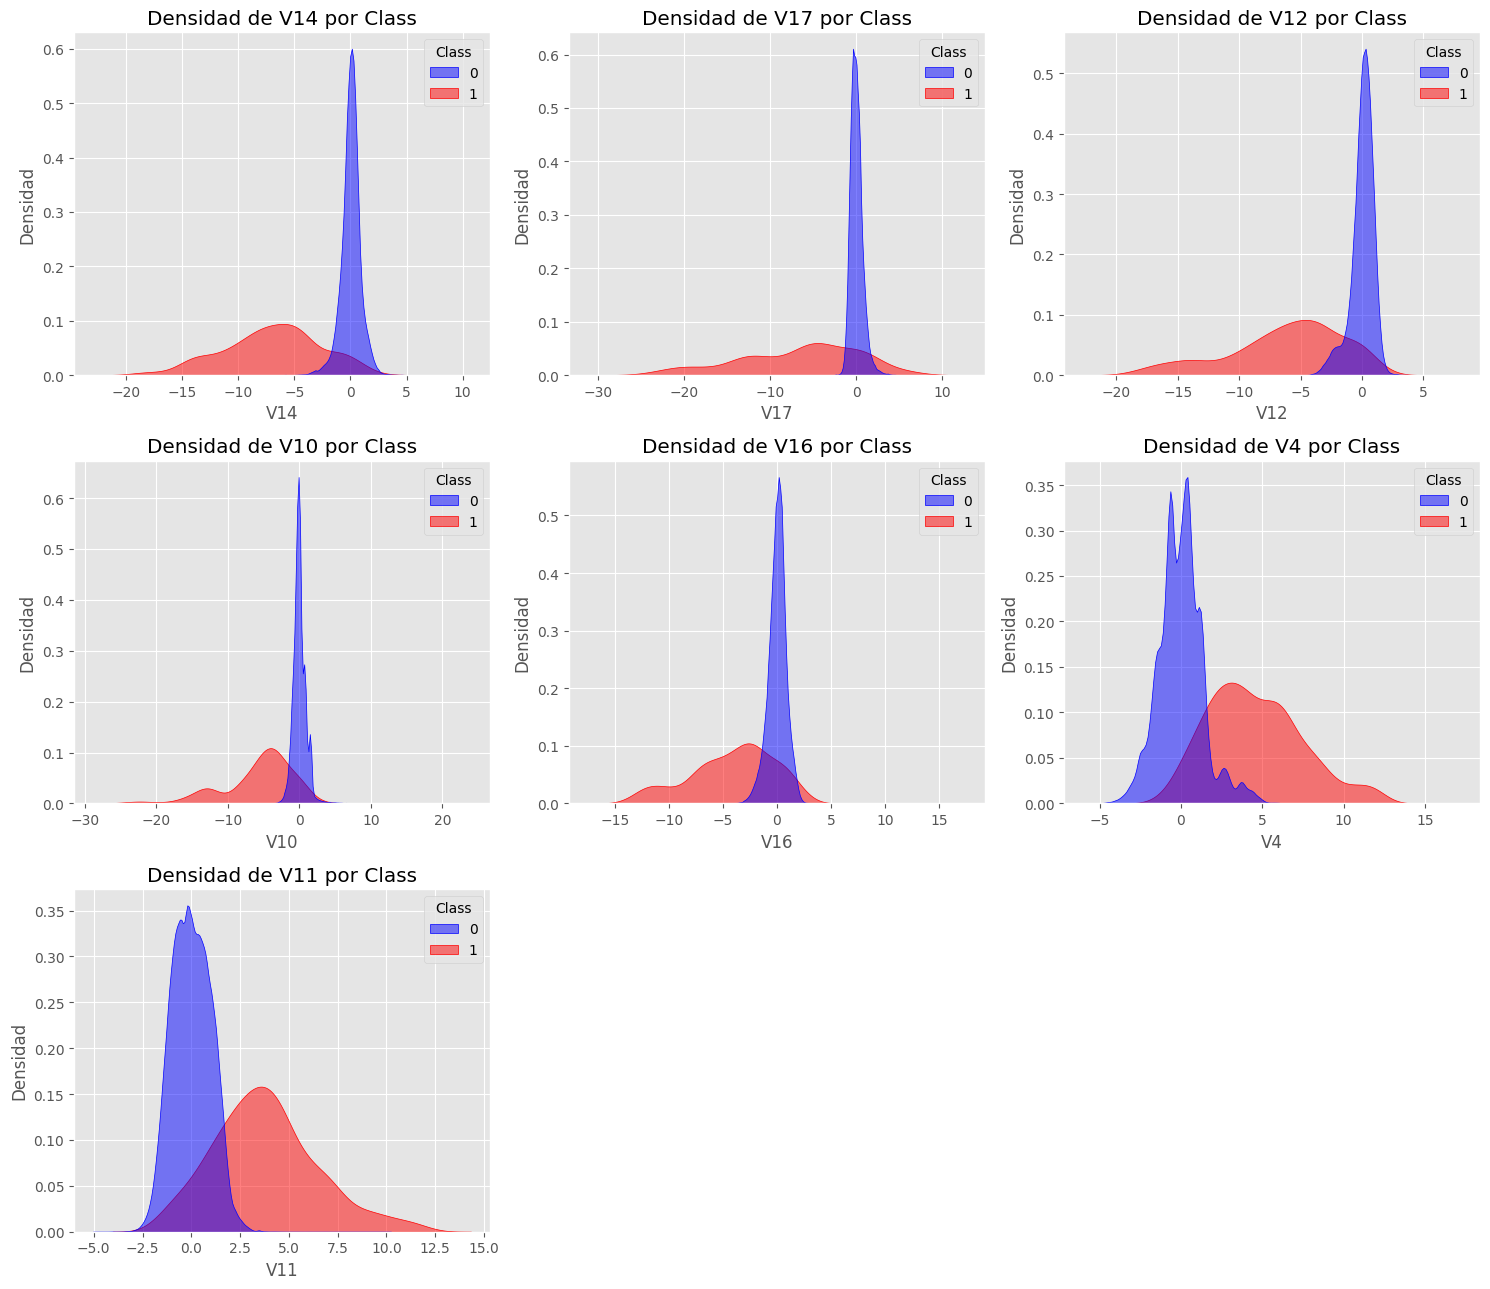

In [12]:
# Configurar subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13))

# Plotear los gráficos de densidad para cada variable por 'Class'
for i, var in enumerate(relevant_variables[:-1]):  # Excluir 'Class'
    row = i // 3
    col = i % 3
    if i < 7:  # Excluir el último gráfico de la tercera fila
        sns.kdeplot(data=filtered_data, x=var, hue='Class', fill=True, common_norm=False, alpha=0.5,
                    palette={0: 'blue', 1: 'red'}, ax=axes[row, col], legend=True)
        axes[row, col].set_title(f'Densidad de {var} por Class')
        axes[row, col].set_xlabel(var)
        axes[row, col].set_ylabel('Densidad')

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

# Ajustar espaciado
plt.tight_layout()
plt.show()

Se observa que la mayoría de las transacciones no fraudulentas (Clase 0) tienen una densidad alta cerca del valor 0, mientras que las transacciones fraudulentas (Clase 1) están más dispersas.

En general, se puede ver que las variables negativamente correlacionadas con ‘Class’ como V14, V17, V12, V10 y V16, tienen una mayor densidad hacia el lado izquierdo del eje x en los casos fraudulentos, lo que indica que los valores más bajos de estas variables se asocian con un mayor riesgo de fraude. Por el contrario, las variables positivamente correlacionadas con ‘Class’ como V4 y V11, tienen una mayor densidad hacia el lado derecho del eje x en los casos fraudulentos, lo que indica que los valores más altos de estas variables se asocian con un mayor riesgo de fraude.

## Preparación de datos para modelos de clasificación.

In [13]:
# Separar las características (X) y la variable objetivo (y)
X = filtered_data.drop('Class', axis=1)
y = filtered_data['Class']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)

# Inicializar el ADASYN
adasyn = ADASYN(random_state=32)

# Aplicar el balanceo de clases
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Inicializar el scaler
scaler = MinMaxScaler()

# Ajustar el scaler con los datos de entrenamiento
scaler.fit(X_train_resampled)

# Transformar los datos de entrenamiento y prueba
X_train_resampled_scaled = scaler.transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

## Random Forest

In [14]:
# Definir la función objetivo para optimizar los hiperparámetros
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    # Convertir los hiperparámetros a tipos de datos enteros donde sea necesario
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    # Inicializar el clasificador Random Forest con los hiperparámetros dados
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                max_features=max_features,
                                random_state=25)
    
    # Calcular la puntuación AUPRC utilizando la validación cruzada
    scores = cross_val_score(rf, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='average_precision')
    
    # Devolver la media de las puntuaciones AUPRC
    return np.mean(scores)

# Definir los límites de búsqueda para cada hiperparámetro
pbounds = {'n_estimators': (50, 500),
           'max_depth': (3, 20),
           'min_samples_split': (2, 20),
           'min_samples_leaf': (1, 10),
           'max_features': (0.1, 1.0)}

# Inicializar el optimizador bayesiano
optimizer = BayesianOptimization(f=rf_cv, pbounds=pbounds, random_state=42)

# Realizar la optimización durante un cierto número de iteraciones
optimizer.maximize(init_points=5, n_iter=5)

# Imprimir los mejores hiperparámetros encontrados y el mejor valor de la función objetivo
print(optimizer.max)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.9759    | 9.367     | 0.9556    | 7.588     | 12.78     | 120.2     |
| 2         | 0.9525    | 5.652     | 0.1523    | 8.796     | 12.82     | 368.6     |
| 3         | 0.9268    | 3.35      | 0.9729    | 8.492     | 5.822     | 131.8     |
| 4         | 0.9649    | 6.118     | 0.3738    | 5.723     | 9.775     | 181.1     |
| 5         | 0.9847    | 13.4      | 0.2255    | 3.629     | 8.595     | 255.2     |
| 6         | 0.9786    | 9.581     | 0.722     | 3.322     | 16.98     | 324.4     |
| 7         | 0.9883    | 18.41     | 0.1948    | 2.325     | 18.66     | 396.8     |
| 8         | 0.9842    | 12.93     | 0.143     | 1.322     | 3.881     | 154.9     |
| 9         | 0.9776    | 10.97     | 0.9937    | 9.297     | 9.773     | 192.0     |
| 10        | 0.9792    | 9.424     | 0.6887    | 4.49

Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo Random Forest: 0.7642189020464686


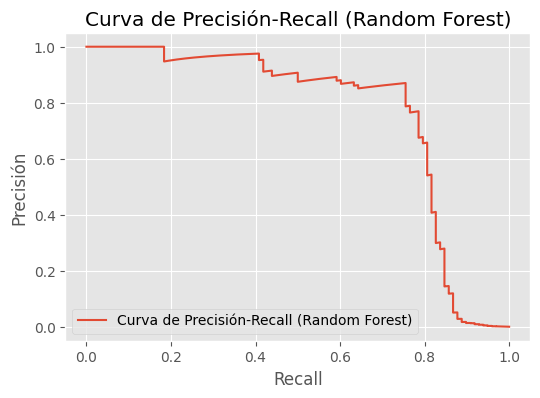

In [15]:
# Obtener los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los hiperparámetros a enteros si es necesario
best_max_depth = int(best_params['max_depth'])
best_min_samples_split = int(best_params['min_samples_split'])
best_min_samples_leaf = int(best_params['min_samples_leaf'])
best_n_estimators = int(best_params['n_estimators'])

# Inicializar el clasificador Random Forest con los mejores hiperparámetros
rf = RandomForestClassifier(max_depth=best_max_depth,
                             min_samples_split=best_min_samples_split,
                             min_samples_leaf=best_min_samples_leaf,
                             n_estimators=best_n_estimators,
                             random_state=28)

# Entrenar el modelo con los datos de entrenamiento
rf.fit(X_train_resampled_scaled, y_train_resampled)

# Hacer predicciones en los datos de prueba
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Calcular el Área Bajo la Curva de Precisión-Recall (AUPRC)
auprc_rf = average_precision_score(y_test, y_pred_proba_rf)
print("Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo Random Forest:", auprc_rf)

# Calcular la curva de precisión-recall
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_proba_rf)

# Plotear la curva de precisión-recall
plt.figure(figsize=(6, 4))
plt.plot(recall_rf, precision_rf, label='Curva de Precisión-Recall (Random Forest)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

In [17]:
def xgb_cv(n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, min_child_weight):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'random_state': 29,
        'objective': 'binary:logistic'
    }

    model = XGBClassifier(**params)
    
    # Utilizamos validación cruzada para evaluar el rendimiento del modelo
    score = cross_val_score(model, X_train_resampled_scaled, y_train_resampled, cv=3, scoring='average_precision').mean()
    
    return score

# Definimos el espacio de búsqueda
xgb_bo = BayesianOptimization(xgb_cv, {
    'n_estimators': (100, 1000),
    'max_depth': (3, 10),
    'learning_rate': (0.001, 0.1),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0.0, 1.0),
    'min_child_weight': (1, 10)
})

# Realizamos la optimización
xgb_bo.maximize(init_points=5, n_iter=5)

# Imprimir los mejores hiperparámetros encontrados y el mejor valor de la función objetivo
print(xgb_bo.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9807    | 0.9496    | 0.4336    | 0.06282   | 5.669     | 9.287     | 737.2     | 0.5826    |
| 2         | 0.9769    | 0.5394    | 0.58      | 0.05029   | 4.31      | 9.266     | 282.3     | 0.8439    |
| 3         | 0.9812    | 0.7989    | 0.419     | 0.02825   | 5.442     | 9.091     | 604.0     | 0.6056    |
| 4         | 0.9818    | 0.7964    | 0.3625    | 0.03197   | 6.656     | 5.478     | 640.7     | 0.5129    |
| 5         | 0.9741    | 0.9432    | 0.9601    | 0.07174   | 3.451     | 1.75      | 271.6     | 0.6016    |
| 6         | 0.9786    | 0.9837    | 0.4012    | 0.003164  | 7.552     | 5.812     | 640.4     | 0.9379    |
| 7         | 0.9716    | 0.7172    | 0.8415    | 0.002001  | 6.545     | 7.558     | 373.4     | 0.7918    |
| 8       

Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo XGBoost: 0.767095645769919


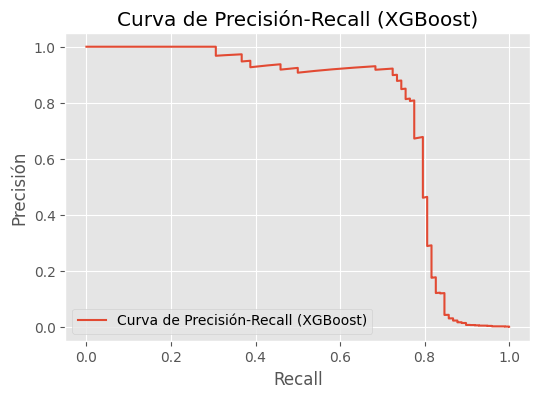

In [18]:
# Extraer los mejores hiperparámetros del optimizador de XGBoost
best_params_xgb = xgb_bo.max['params']

# Redondear los hiperparámetros a enteros si es necesario
best_max_depth_xgb = int(best_params_xgb['max_depth'])
best_learning_rate_xgb = best_params_xgb['learning_rate']
best_subsample_xgb = best_params_xgb['subsample']
best_colsample_bytree_xgb = best_params_xgb['colsample_bytree']
best_gamma_xgb = best_params_xgb['gamma']
best_min_child_weight_xgb = int(best_params_xgb['min_child_weight'])
best_n_estimators_xgb = int(best_params_xgb['n_estimators'])

# Crear y entrenar el modelo de XGBoost con los mejores hiperparámetros encontrados
xgb_model = XGBClassifier(max_depth=best_max_depth_xgb,
                          learning_rate=best_learning_rate_xgb,
                          subsample=best_subsample_xgb,
                          colsample_bytree=best_colsample_bytree_xgb,
                          gamma=best_gamma_xgb,
                          min_child_weight=best_min_child_weight_xgb,
                          n_estimators=best_n_estimators_xgb,
                          random_state=21)

# Entrenar el modelo con los datos de entrenamiento
xgb_model.fit(X_train_resampled_scaled, y_train_resampled)

# Hacer predicciones de probabilidad en los datos de prueba
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calcular el Área Bajo la Curva de Precisión-Recall (AUPRC)
auprc_xgb = average_precision_score(y_test, y_pred_proba_xgb)
print("Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo XGBoost:", auprc_xgb)

# Calcular la curva de precisión-recall
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_pred_proba_xgb)

# Plotear la curva de precisión-recall
plt.figure(figsize=(6, 4))
plt.plot(recall_xgb, precision_xgb, label='Curva de Precisión-Recall (XGBoost)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

## CatBoost

In [19]:
# Define la función objetivo para la optimización
def catboost_cv(learning_rate, depth, l2_leaf_reg, bagging_temperature):
    params = {
        'learning_rate': learning_rate,
        'depth': int(depth),
        'l2_leaf_reg': l2_leaf_reg,
        'bagging_temperature': bagging_temperature,
        'iterations': 1000,  # Número fijo de iteraciones
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': False
    }
    # Inicializa el clasificador CatBoost con los hiperparámetros dados
    clf = CatBoostClassifier(**params)

    # Utiliza validación cruzada para evaluar el rendimiento del modelo
    scores = cross_val_score(clf, X_train_resampled_scaled, y_train_resampled, cv=3, scoring='average_precision')

    # Devuelve la media de las puntuaciones de validación cruzada
    return scores.mean()

# Define el espacio de búsqueda para cada hiperparámetro
catboost_bo = BayesianOptimization(
    catboost_cv,
    {
        'learning_rate': (0.01, 0.3),
        'depth': (3, 10),
        'l2_leaf_reg': (0.1, 10),
        'bagging_temperature': (0.1, 1)
    }
)

# Realiza la optimización
catboost_bo.maximize(init_points=5, n_iter=5)

# Imprime los mejores hiperparámetros encontrados y el mejor valor de la función objetivo
print(catboost_bo.max)

|   iter    |  target   | baggin... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------
| 1         | 0.9815    | 0.8084    | 7.287     | 8.62      | 0.1929    |
| 2         | 0.9814    | 0.2636    | 5.384     | 2.114     | 0.1083    |
| 3         | 0.9787    | 0.828     | 3.652     | 8.782     | 0.2487    |
| 4         | 0.9841    | 0.1105    | 8.147     | 8.269     | 0.1749    |
| 5         | 0.9813    | 0.7776    | 6.096     | 6.716     | 0.1669    |
| 6         | 0.9841    | 0.2706    | 8.551     | 8.405     | 0.02822   |
| 7         | 0.9851    | 0.1       | 9.323     | 6.726     | 0.3       |
| 8         | 0.9854    | 0.1       | 10.0      | 3.64      | 0.01      |
| 9         | 0.9844    | 0.1       | 10.0      | 0.1       | 0.3       |
| 10        | 0.9849    | 1.0       | 10.0      | 2.169     | 0.3       |
{'target': 0.9853668402968014, 'params': {'bagging_temperature': 0.1, 'depth': 10.0, 'l2_leaf_reg': 3.6399739721

Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo CatBoost: 0.7520043318518358


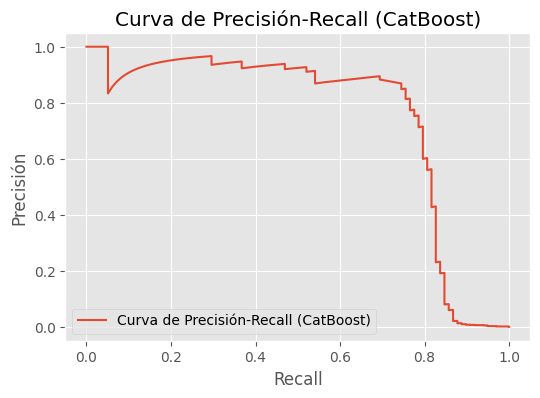

In [20]:
# Extraer los mejores hiperparámetros de la optimización
best_params_catboost = catboost_bo.max['params']

# Convertir los hiperparámetros a tipos de datos adecuados
best_params_catboost['depth'] = int(best_params_catboost['depth'])

# Crear y entrenar el modelo CatBoost con los mejores hiperparámetros encontrados
clf_catboost = CatBoostClassifier(iterations=1000,  # Puedes ajustar el número de iteraciones según sea necesario
                                  eval_metric='AUC',
                                  random_seed=42,
                                  verbose=False,
                                  **best_params_catboost)

clf_catboost.fit(X_train_resampled_scaled, y_train_resampled)

# Hacer predicciones de probabilidades en los datos de prueba
y_pred_proba_catboost = clf_catboost.predict_proba(X_test_scaled)[:, 1]

# Calcular el Área Bajo la Curva de Precisión-Recall (AUPRC)
auprc_catboost = average_precision_score(y_test, y_pred_proba_catboost)
print("Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo CatBoost:", auprc_catboost)

# Calcular la curva de precisión-recall
precision_catboost, recall_catboost, thresholds_catboost = precision_recall_curve(y_test, y_pred_proba_catboost)

# Plotear la curva de precisión-recall
plt.figure(figsize=(6, 4))
plt.plot(recall_catboost, precision_catboost, label='Curva de Precisión-Recall (CatBoost)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall (CatBoost)')
plt.legend()
plt.grid(True)
plt.show()

## LightGBM

In [14]:
# Define la función objetivo para la optimización de LightGBM
def lgb_cv(learning_rate, num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'max_depth': int(max_depth),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbosity': -1,
        'seed': 42
    }
    
    # Inicializa el clasificador LightGBM con los hiperparámetros dados
    clf = LGBMClassifier(**params)
    
    # Utiliza validación cruzada para evaluar el rendimiento del modelo
    scores = cross_val_score(clf, X_train_resampled_scaled, y_train_resampled, cv=3, scoring='average_precision')
    
    # Devuelve la media de las puntuaciones de validación cruzada
    return scores.mean()

# Define el espacio de búsqueda para cada hiperparámetro
lgb_bo = BayesianOptimization(lgb_cv, {
    'learning_rate': (0.01, 0.3),
    'num_leaves': (20, 100),
    'feature_fraction': (0.5, 1.0),
    'bagging_fraction': (0.5, 1.0),
    'max_depth': (3, 10),
    'min_split_gain': (0.0, 1.0),
    'min_child_weight': (1, 10)
})

# Realiza la optimización
lgb_bo.maximize(init_points=5, n_iter=5)

# Imprime los mejores hiperparámetros encontrados y el mejor valor de la función objetivo
print(lgb_bo.max)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------


  File "C:\Users\Pedro\anaconda3\envs\fraud_detection\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


| 1         | 0.9831    | 0.6521    | 0.5564    | 0.07851   | 7.538     | 1.213     | 0.424     | 55.5      |
| 2         | 0.9673    | 0.6286    | 0.7881    | 0.09488   | 3.688     | 2.007     | 0.7951    | 46.57     |
| 3         | 0.9814    | 0.6129    | 0.5639    | 0.2876    | 9.77      | 1.946     | 0.3894    | 40.49     |
| 4         | 0.9812    | 0.6617    | 0.5918    | 0.1836    | 7.903     | 8.35      | 0.8895    | 60.54     |
| 5         | 0.9751    | 0.6165    | 0.5287    | 0.1135    | 4.579     | 8.372     | 0.8496    | 94.05     |
| 6         | 0.98      | 0.5771    | 0.6347    | 0.2116    | 5.577     | 1.17      | 0.1756    | 99.89     |
| 7         | 0.9773    | 0.5999    | 0.795     | 0.1486    | 4.476     | 2.251     | 0.01742   | 24.28     |
| 8         | 0.9801    | 0.9973    | 0.9302    | 0.1088    | 6.904     | 8.687     | 0.7552    | 59.84     |
| 9         | 0.9828    | 0.5       | 0.5       | 0.2233    | 9.085     | 3.129     | 0.7601    | 59.03     |
| 10      

Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM: 0.7820118802900113


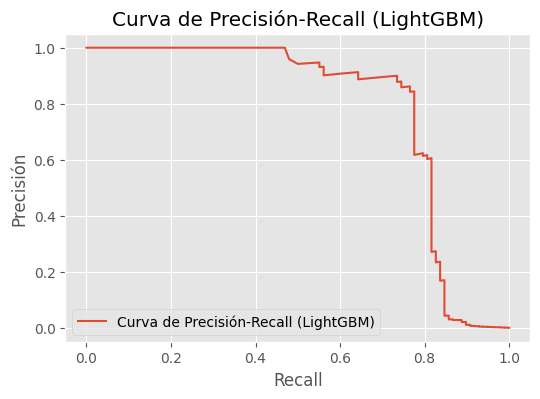

In [16]:
# Extrae los mejores hiperparámetros de la optimización
best_params_lgbm = lgb_bo.max['params']

# Convierte los hiperparámetros a tipos de datos adecuados
best_params_lgbm['num_leaves'] = int(best_params_lgbm['num_leaves'])
best_params_lgbm['max_depth'] = int(best_params_lgbm['max_depth'])

# Crea y entrena el modelo LightGBM con los mejores hiperparámetros encontrados
clf_lgbm = LGBMClassifier(**best_params_lgbm, verbose=-1, random_state=55)
clf_lgbm.fit(X_train_resampled_scaled, y_train_resampled)

# Realiza predicciones de probabilidades en los datos de prueba
y_pred_proba_lgbm = clf_lgbm.predict_proba(X_test_scaled)[:, 1]

# Calcula el Área Bajo la Curva de Precisión-Recall (AUPRC)
auprc_lgbm = average_precision_score(y_test, y_pred_proba_lgbm)
print("Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM:", auprc_lgbm)

# Calcula la curva de precisión-recall
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)

# Grafica la curva de precisión-recall
plt.figure(figsize=(6, 4))
plt.plot(recall_lgbm, precision_lgbm, label='Curva de Precisión-Recall (LightGBM)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall (LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

Como siguiente paso, se realizará una optimización más exhaustiva para XGBoost y LightGBM. No se usará Random Forest debido al tiempo de optimización demasiado elevado y no se usará CatBoost debido a que tuvo el AUPRC más bajo.

In [27]:
def xgb_cv(n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, min_child_weight):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'random_state': 34,
        'objective': 'binary:logistic'
    }

    model = XGBClassifier(**params)
    
    # Utilizamos validación cruzada para evaluar el rendimiento del modelo
    score = cross_val_score(model, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='average_precision').mean()
    
    return score

# Define el espacio de búsqueda para cada hiperparámetro utilizando distribuciones de probabilidad
pbounds = {
    'n_estimators': (100, 2000),
    'max_depth': (3, 15),
    'learning_rate': (0.0001, 0.1),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0.0, 3.0),
    'min_child_weight': (1, 10)
}

# Realiza la optimización más exhaustiva
xgb_bo = BayesianOptimization(xgb_cv, pbounds)
xgb_bo.maximize(init_points=10, n_iter=50)

# Imprime los mejores hiperparámetros encontrados y el mejor valor de la función objetivo
print(xgb_bo.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.983     | 0.5558    | 0.5201    | 0.0492    | 4.891     | 5.105     | 674.7     | 0.8589    |
| 2         | 0.9865    | 0.7779    | 2.24      | 0.07234   | 12.93     | 1.37      | 376.4     | 0.6267    |
| 3         | 0.9851    | 0.8403    | 2.484     | 0.01989   | 8.921     | 4.916     | 1.501e+03 | 0.8589    |
| 4         | 0.9894    | 0.9066    | 1.126     | 0.03228   | 14.86     | 1.921     | 551.4     | 0.9488    |
| 5         | 0.9864    | 0.7815    | 1.862     | 0.01598   | 11.28     | 4.313     | 718.9     | 0.6799    |
| 6         | 0.9587    | 0.8492    | 2.602     | 0.0013    | 5.335     | 3.591     | 197.1     | 0.8732    |
| 7         | 0.9843    | 0.7401    | 1.675     | 0.04824   | 5.396     | 7.596     | 1.668e+03 | 0.5693    |
| 8       

Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo XGBoost: 0.7768926752298585


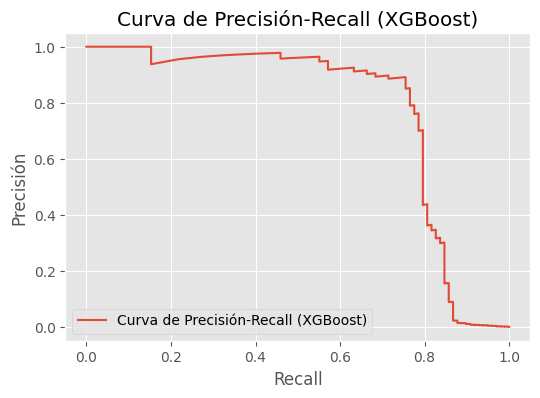

In [28]:
# Extraer los mejores hiperparámetros del optimizador de XGBoost
best_params_xgb = xgb_bo.max['params']

# Redondear los hiperparámetros a enteros si es necesario
best_max_depth_xgb = int(best_params_xgb['max_depth'])
best_learning_rate_xgb = best_params_xgb['learning_rate']
best_subsample_xgb = best_params_xgb['subsample']
best_colsample_bytree_xgb = best_params_xgb['colsample_bytree']
best_gamma_xgb = best_params_xgb['gamma']
best_min_child_weight_xgb = int(best_params_xgb['min_child_weight'])
best_n_estimators_xgb = int(best_params_xgb['n_estimators'])

# Crear y entrenar el modelo de XGBoost con los mejores hiperparámetros encontrados
xgb_model = XGBClassifier(max_depth=best_max_depth_xgb,
                          learning_rate=best_learning_rate_xgb,
                          subsample=best_subsample_xgb,
                          colsample_bytree=best_colsample_bytree_xgb,
                          gamma=best_gamma_xgb,
                          min_child_weight=best_min_child_weight_xgb,
                          n_estimators=best_n_estimators_xgb,
                          random_state=28)

# Entrenar el modelo con los datos de entrenamiento
xgb_model.fit(X_train_resampled_scaled, y_train_resampled)

# Hacer predicciones de probabilidad en los datos de prueba
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calcular el Área Bajo la Curva de Precisión-Recall (AUPRC)
auprc_xgb = average_precision_score(y_test, y_pred_proba_xgb)
print("Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo XGBoost:", auprc_xgb)

# Calcular la curva de precisión-recall
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_pred_proba_xgb)

# Plotear la curva de precisión-recall
plt.figure(figsize=(6, 4))
plt.plot(recall_xgb, precision_xgb, label='Curva de Precisión-Recall (XGBoost)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

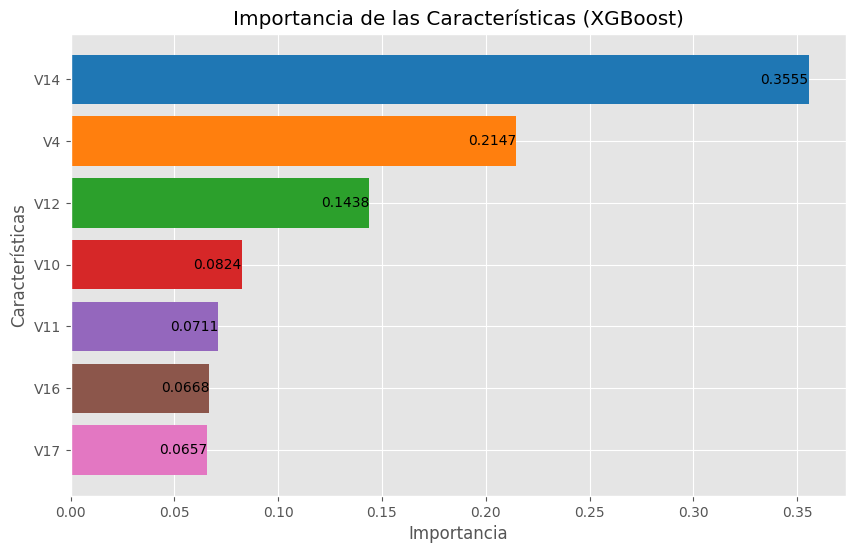

In [30]:
# Calcular la importancia de las características
feature_importance = xgb_model.feature_importances_

# Obtener los índices ordenados por importancia
sorted_indices = np.argsort(feature_importance)[::-1]

# Obtener los nombres de las características ordenadas por importancia
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]

# Obtener la importancia de las características ordenada
sorted_feature_importance = feature_importance[sorted_indices]

# Crear un mapa de colores categóricos
cmap = plt.get_cmap('tab10')

# Gráfico para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, 
                color=cmap(range(len(sorted_feature_importance))))
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características (XGBoost)')
plt.gca().invert_yaxis()

# Agregar valores de las barras
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, '{:.4f}'.format(sorted_feature_importance[i]), 
             va='center', ha='right')

plt.show()

In [65]:
# Define la función objetivo para la optimización de LightGBM
def lgbm_cv(learning_rate, num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, reg_alpha, reg_lambda, n_estimators):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'max_depth': int(max_depth),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'n_estimators': int(n_estimators),
        'verbosity': -1,
        'seed': 42
    }
    
    # Inicializa el clasificador LightGBM con los hiperparámetros dados
    clf = LGBMClassifier(**params, verbose=-1)
    
    # Utiliza validación cruzada para evaluar el rendimiento del modelo
    scores = cross_val_score(clf, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='average_precision')
    
    # Devuelve la media de las puntuaciones de validación cruzada
    return scores.mean()

# Define el espacio de búsqueda para cada hiperparámetro utilizando distribuciones de probabilidad
pbounds = {
    'learning_rate': (0.001, 0.5),
    'num_leaves': (10, 200),
    'feature_fraction': (0.0, 1.0),
    'bagging_fraction': (0.1, 1.0),
    'max_depth': (2, 15),
    'min_split_gain': (0.001, 1.0),
    'min_child_weight': (0.5, 20),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0),
    'n_estimators': (50, 1000)
}

# Realiza la optimización
lgbm_bo = BayesianOptimization(lgbm_cv, pbounds)
lgbm_bo.maximize(init_points=10, n_iter=50)

# Imprime los mejores hiperparámetros encontrados y el mejor valor de la función objetivo
print(lgbm_bo.max)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9536    | 0.4671    | 0.1644    | 0.4104    | 2.866     | 12.73     | 0.1071    | 394.2     | 98.87     | 0.5483    | 0.1528    |
| 2         | 0.9836    | 0.6872    | 0.9398    | 0.1688    | 8.185     | 8.035     | 0.3597    | 146.2     | 60.91     | 0.9352    | 0.01182   |
| 3         | 0.9796    | 0.7996    | 0.3564    | 0.2772    | 8.623     | 6.039     | 0.04068   | 577.4     | 117.7     | 0.2975    | 0.7396    |
| 4         | 0.9851    | 0.4259    | 0.5765    | 0.3002    | 11.5      | 9.426     | 0.9404    | 156.7     | 84.34     | 0.958     | 0.2677    |
| 5         | 0.9832    | 0.3507    | 0.4932    | 0.2842    | 10.79     | 17.73     | 0.8546    | 94.42     | 148.3     | 0.

Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM: 0.7916863626528505


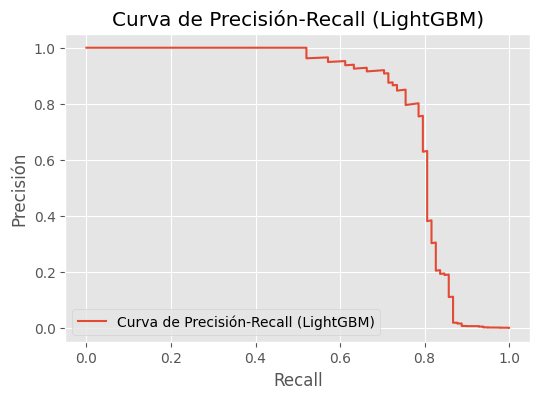

In [68]:
# Extrae los mejores hiperparámetros de la optimización
best_params_lgbm = lgbm_bo.max['params']

# Convierte los hiperparámetros a tipos de datos adecuados
best_params_lgbm['num_leaves'] = int(best_params_lgbm['num_leaves'])
best_params_lgbm['max_depth'] = int(best_params_lgbm['max_depth'])
best_params_lgbm['n_estimators'] = int(best_params_lgbm['n_estimators'])

# Crea y entrena el modelo LightGBM con los mejores hiperparámetros encontrados
clf_lgbm = LGBMClassifier(random_state=65, **best_params_lgbm, verbose=-1)
clf_lgbm.fit(X_train_resampled_scaled, y_train_resampled)

# Realiza predicciones de probabilidades en los datos de prueba
y_pred_proba_lgbm = clf_lgbm.predict_proba(X_test_scaled)[:, 1]

# Calcula el Área Bajo la Curva de Precisión-Recall (AUPRC)
auprc_lgbm = average_precision_score(y_test, y_pred_proba_lgbm)
print("Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM:", auprc_lgbm)

# Calcula la curva de precisión-recall
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)

# Grafica la curva de precisión-recall
plt.figure(figsize=(6, 4))
plt.plot(recall_lgbm, precision_lgbm, label='Curva de Precisión-Recall (LightGBM)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall (LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

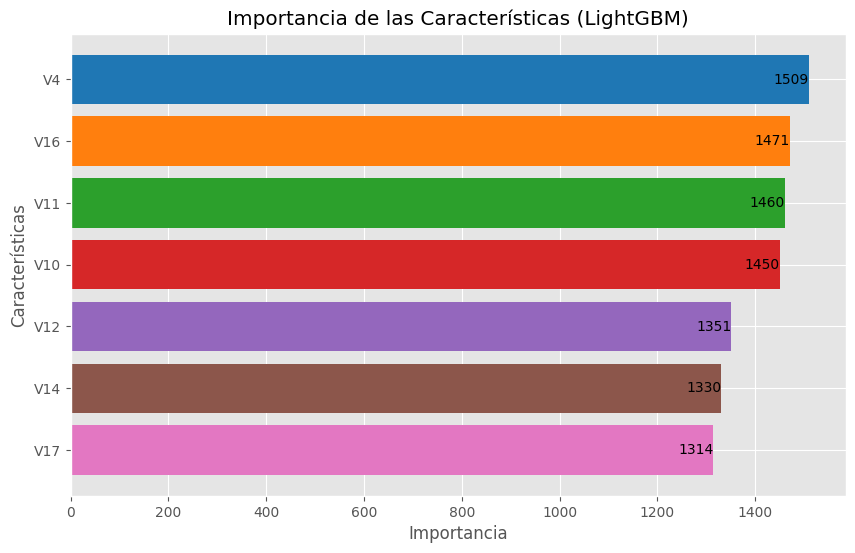

In [69]:
# Obtener la importancia de las características
feature_importance = clf_lgbm.feature_importances_

# Obtener los índices ordenados por importancia
sorted_indices = np.argsort(feature_importance)[::-1]

# Obtener los nombres de las características ordenadas por importancia
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]

# Obtener la importancia de las características ordenada
sorted_feature_importance = feature_importance[sorted_indices]

# Crear un mapa de colores categóricos
cmap = plt.get_cmap('tab10')

# Gráfico para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, 
                color=cmap(range(len(sorted_feature_importance))))
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características (LightGBM)')
plt.gca().invert_yaxis()

# Agregar valores de las barras
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, '{:.0f}'.format(sorted_feature_importance[i]), 
             va='center', ha='right')

plt.show()

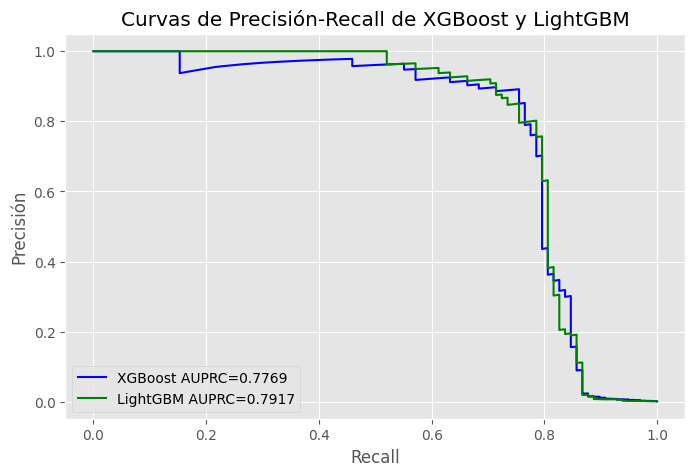

In [71]:
# Graficar ambas curvas AUPRC
plt.figure(figsize=(8, 5))

# Curva de precisión-recall de XGBoost
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost AUPRC={auprc_xgb:.4f}', color='blue')

# Curva de precisión-recall de LightGBM
plt.plot(recall_lgbm, precision_lgbm, label=f'LightGBM AUPRC={auprc_lgbm:.4f}', color='green')

# Configuraciones adicionales del gráfico
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curvas de Precisión-Recall de XGBoost y LightGBM')
plt.legend()
plt.grid(True)
plt.show()

A modo de prueba se implementarán otros métodos de optimización para LightGBM.

### Hyperopt

In [73]:
# Definir la función objetivo para la optimización de LightGBM
def lgbm_cv(params):
    # Convertir parámetros continuos a valores reales
    params['learning_rate'] = params['learning_rate']
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    # Inicializar el clasificador LightGBM con los hiperparámetros dados
    clf = LGBMClassifier(**params, verbose=-1)
    
    # Utilizar validación cruzada para evaluar el rendimiento del modelo
    scores = cross_val_score(clf, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='average_precision')
    
    # Devolver la media de las puntuaciones de validación cruzada
    return {'loss': -scores.mean(), 'status': STATUS_OK}

# Espacio de búsqueda de hiperparámetros
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.0, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1.0),
    'max_depth': hp.quniform('max_depth', 2, 15, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0.001, 1.0),
    'min_child_weight': hp.uniform('min_child_weight', 0.5, 20),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1)
}

# Función para la optimización
def optimize(space):
    trials = Trials()
    best = fmin(fn=lgbm_cv,
                space=space,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials)
    return best

# Realizar la optimización
best_params = optimize(space)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(best_params)

100%|██████████| 50/50 [21:18<00:00, 25.58s/trial, best loss: -0.9868479050194706]
Mejores hiperparámetros encontrados:
{'bagging_fraction': 0.8249331170472203, 'feature_fraction': 0.7758434938117182, 'learning_rate': 0.17807880185747604, 'max_depth': 15.0, 'min_child_weight': 12.210497399013985, 'min_split_gain': 0.8907283999549277, 'n_estimators': 248.0, 'num_leaves': 145.0, 'reg_alpha': 0.3684174317806527, 'reg_lambda': 0.7736881467428828}


Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM: 0.7891486921109959


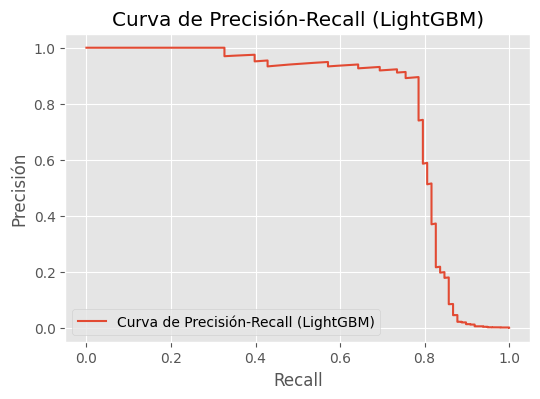

In [74]:
# Extrae los mejores hiperparámetros de la optimización
best_params_lgbm = best_params

# Convierte los hiperparámetros a tipos de datos adecuados
best_params_lgbm['num_leaves'] = int(best_params_lgbm['num_leaves'])
best_params_lgbm['max_depth'] = int(best_params_lgbm['max_depth'])
best_params_lgbm['n_estimators'] = int(best_params_lgbm['n_estimators'])

# Crea y entrena el modelo LightGBM con los mejores hiperparámetros encontrados
clf_lgbm = LGBMClassifier(random_state=68, **best_params_lgbm, verbose=-1)
clf_lgbm.fit(X_train_resampled_scaled, y_train_resampled)

# Realiza predicciones de probabilidades en los datos de prueba
y_pred_proba_lgbm = clf_lgbm.predict_proba(X_test_scaled)[:, 1]

# Calcula el Área Bajo la Curva de Precisión-Recall (AUPRC)
auprc_lgbm = average_precision_score(y_test, y_pred_proba_lgbm)
print("Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM:", auprc_lgbm)

# Calcula la curva de precisión-recall
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)

# Grafica la curva de precisión-recall
plt.figure(figsize=(6, 4))
plt.plot(recall_lgbm, precision_lgbm, label='Curva de Precisión-Recall (LightGBM)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall (LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

### Optuna

In [7]:
# Definir la función objetivo para la optimización de Optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.0, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.001, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000)
    }

    # Inicializar el clasificador LightGBM con los hiperparámetros propuestos por Optuna
    clf = LGBMClassifier(**params, random_state=45, verbose=-1)
    
    # Calcular la métrica de evaluación (AUPRC) mediante validación cruzada
    auprc_scores = cross_val_score(clf, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='average_precision')
    mean_auprc = auprc_scores.mean()

    return mean_auprc

# Configurar y ejecutar el estudio de optimización de Optuna con impresión de progreso
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[lambda study, trial: print(f"Trial {trial.number+1}/{len(study.trials)}: Best Value {study.best_value}")])

# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params
print("Mejores hiperparámetros encontrados:", best_params)

[I 2024-03-04 17:32:15,892] A new study created in memory with name: no-name-37ffd002-2569-40ae-a2ba-cf9e5320b369
[I 2024-03-04 17:32:30,934] Trial 0 finished with value: 0.9521556191428324 and parameters: {'learning_rate': 0.24909249940942943, 'num_leaves': 175, 'feature_fraction': 0.16076795788979237, 'bagging_fraction': 0.9446891120054582, 'max_depth': 14, 'min_split_gain': 0.2829293078161212, 'min_child_weight': 19.29927075546268, 'reg_alpha': 0.9155810724783697, 'reg_lambda': 0.09948954985341985, 'n_estimators': 281}. Best is trial 0 with value: 0.9521556191428324.


Trial 1/1: Best Value 0.9521556191428324


[I 2024-03-04 17:33:08,065] Trial 1 finished with value: 0.9837707812508952 and parameters: {'learning_rate': 0.24600717140591902, 'num_leaves': 200, 'feature_fraction': 0.9170063779613377, 'bagging_fraction': 0.1619899490567827, 'max_depth': 4, 'min_split_gain': 0.1974862375062796, 'min_child_weight': 3.7344533290065502, 'reg_alpha': 0.513354879928455, 'reg_lambda': 0.35756360190398373, 'n_estimators': 824}. Best is trial 1 with value: 0.9837707812508952.


Trial 2/2: Best Value 0.9837707812508952


[I 2024-03-04 17:33:37,931] Trial 2 finished with value: 0.9528409661093246 and parameters: {'learning_rate': 0.17556173416009574, 'num_leaves': 97, 'feature_fraction': 0.19878485116953937, 'bagging_fraction': 0.5937797062383577, 'max_depth': 10, 'min_split_gain': 0.999679158313337, 'min_child_weight': 10.801524715376368, 'reg_alpha': 0.9388329721581716, 'reg_lambda': 0.546488710527489, 'n_estimators': 600}. Best is trial 1 with value: 0.9837707812508952.


Trial 3/3: Best Value 0.9837707812508952


[I 2024-03-04 17:34:19,431] Trial 3 finished with value: 0.9511563671631004 and parameters: {'learning_rate': 0.025900177215068307, 'num_leaves': 162, 'feature_fraction': 0.11575258085468698, 'bagging_fraction': 0.5470466793111375, 'max_depth': 13, 'min_split_gain': 0.461230400152523, 'min_child_weight': 13.18471730849855, 'reg_alpha': 0.8870377300307726, 'reg_lambda': 0.734144583081133, 'n_estimators': 620}. Best is trial 1 with value: 0.9837707812508952.


Trial 4/4: Best Value 0.9837707812508952


[I 2024-03-04 17:34:41,821] Trial 4 finished with value: 0.9376932289411091 and parameters: {'learning_rate': 0.003310083625358436, 'num_leaves': 113, 'feature_fraction': 0.03219078202856185, 'bagging_fraction': 0.3029334753102091, 'max_depth': 13, 'min_split_gain': 0.8453238566629652, 'min_child_weight': 13.295175909796928, 'reg_alpha': 0.5705775706772377, 'reg_lambda': 0.3462004112730773, 'n_estimators': 302}. Best is trial 1 with value: 0.9837707812508952.


Trial 5/5: Best Value 0.9837707812508952


[I 2024-03-04 17:35:19,544] Trial 5 finished with value: 0.9757723021212303 and parameters: {'learning_rate': 0.022230211948128627, 'num_leaves': 12, 'feature_fraction': 0.30353555823593614, 'bagging_fraction': 0.7761725442619787, 'max_depth': 8, 'min_split_gain': 0.5127396192237046, 'min_child_weight': 17.30789910258822, 'reg_alpha': 0.9281978012116169, 'reg_lambda': 0.653722427679097, 'n_estimators': 754}. Best is trial 1 with value: 0.9837707812508952.


Trial 6/6: Best Value 0.9837707812508952


[I 2024-03-04 17:35:27,958] Trial 6 finished with value: 0.9868310451466188 and parameters: {'learning_rate': 0.08459377894224068, 'num_leaves': 129, 'feature_fraction': 0.7569536809533911, 'bagging_fraction': 0.6615714921018925, 'max_depth': 14, 'min_split_gain': 0.12363061118257715, 'min_child_weight': 1.6188089028628716, 'reg_alpha': 0.8055791530511851, 'reg_lambda': 0.4863871187371719, 'n_estimators': 54}. Best is trial 6 with value: 0.9868310451466188.


Trial 7/7: Best Value 0.9868310451466188


[I 2024-03-04 17:35:43,978] Trial 7 finished with value: 0.9844027124865444 and parameters: {'learning_rate': 0.35177694122310094, 'num_leaves': 140, 'feature_fraction': 0.43115480178529564, 'bagging_fraction': 0.8225475299747962, 'max_depth': 10, 'min_split_gain': 0.1321661514278262, 'min_child_weight': 17.269952052099452, 'reg_alpha': 0.21630861212844998, 'reg_lambda': 0.6941458212250151, 'n_estimators': 184}. Best is trial 6 with value: 0.9868310451466188.


Trial 8/8: Best Value 0.9868310451466188


[I 2024-03-04 17:36:08,108] Trial 8 finished with value: 0.985765556021114 and parameters: {'learning_rate': 0.16802000444833384, 'num_leaves': 146, 'feature_fraction': 0.8826982046279853, 'bagging_fraction': 0.14745088341638835, 'max_depth': 13, 'min_split_gain': 0.8372421776721802, 'min_child_weight': 7.302309186655356, 'reg_alpha': 0.6332311077506245, 'reg_lambda': 0.2794849695198711, 'n_estimators': 684}. Best is trial 6 with value: 0.9868310451466188.


Trial 9/9: Best Value 0.9868310451466188


[I 2024-03-04 17:36:37,763] Trial 9 finished with value: 0.9843961559072891 and parameters: {'learning_rate': 0.11061216821005491, 'num_leaves': 69, 'feature_fraction': 0.3799934769995936, 'bagging_fraction': 0.7605770990360002, 'max_depth': 12, 'min_split_gain': 0.8816658809994674, 'min_child_weight': 5.429475647971195, 'reg_alpha': 0.8243832375355884, 'reg_lambda': 0.8837306547367006, 'n_estimators': 681}. Best is trial 6 with value: 0.9868310451466188.


Trial 10/10: Best Value 0.9868310451466188


[I 2024-03-04 17:36:43,968] Trial 10 finished with value: 0.9829871688577724 and parameters: {'learning_rate': 0.47512427494211124, 'num_leaves': 46, 'feature_fraction': 0.660183517236485, 'bagging_fraction': 0.4939915233379604, 'max_depth': 6, 'min_split_gain': 0.01705026113579458, 'min_child_weight': 1.2943834016259306, 'reg_alpha': 0.2379640719776488, 'reg_lambda': 8.36021693593203e-05, 'n_estimators': 73}. Best is trial 6 with value: 0.9868310451466188.


Trial 11/11: Best Value 0.9868310451466188


[I 2024-03-04 17:37:12,187] Trial 11 finished with value: 0.9864061489588938 and parameters: {'learning_rate': 0.1443998015615718, 'num_leaves': 127, 'feature_fraction': 0.8672528520117163, 'bagging_fraction': 0.1065971976085387, 'max_depth': 15, 'min_split_gain': 0.6195315895420808, 'min_child_weight': 6.948478695391189, 'reg_alpha': 0.6863718431158351, 'reg_lambda': 0.287030712854364, 'n_estimators': 998}. Best is trial 6 with value: 0.9868310451466188.


Trial 12/12: Best Value 0.9868310451466188


[I 2024-03-04 17:37:41,140] Trial 12 finished with value: 0.9876576570749573 and parameters: {'learning_rate': 0.11516446080136906, 'num_leaves': 120, 'feature_fraction': 0.6548820639654865, 'bagging_fraction': 0.3701761150238094, 'max_depth': 15, 'min_split_gain': 0.5843286836602175, 'min_child_weight': 0.5500558782240184, 'reg_alpha': 0.6890075222083298, 'reg_lambda': 0.22561464457208713, 'n_estimators': 949}. Best is trial 12 with value: 0.9876576570749573.


Trial 13/13: Best Value 0.9876576570749573


[I 2024-03-04 17:38:06,360] Trial 13 finished with value: 0.9873854426753035 and parameters: {'learning_rate': 0.085946175099502, 'num_leaves': 92, 'feature_fraction': 0.6554525296145339, 'bagging_fraction': 0.3837645002202852, 'max_depth': 15, 'min_split_gain': 0.341787668526248, 'min_child_weight': 0.6603268486908882, 'reg_alpha': 0.40725383127290016, 'reg_lambda': 0.49951355144781723, 'n_estimators': 442}. Best is trial 12 with value: 0.9876576570749573.


Trial 14/14: Best Value 0.9876576570749573


[I 2024-03-04 17:38:26,403] Trial 14 finished with value: 0.9791471511244998 and parameters: {'learning_rate': 0.34440677391671537, 'num_leaves': 85, 'feature_fraction': 0.6257941564733802, 'bagging_fraction': 0.38182811849154746, 'max_depth': 2, 'min_split_gain': 0.37483620721014116, 'min_child_weight': 0.7676846437585012, 'reg_alpha': 0.35837645085488035, 'reg_lambda': 0.13717739047736, 'n_estimators': 448}. Best is trial 12 with value: 0.9876576570749573.


Trial 15/15: Best Value 0.9876576570749573


[I 2024-03-04 17:38:57,362] Trial 15 finished with value: 0.9856932330819788 and parameters: {'learning_rate': 0.08246086479928516, 'num_leaves': 67, 'feature_fraction': 0.5612585608042582, 'bagging_fraction': 0.3661822026281528, 'max_depth': 11, 'min_split_gain': 0.6651939495558219, 'min_child_weight': 4.029789001610201, 'reg_alpha': 0.0009337782758698232, 'reg_lambda': 0.9909545304616488, 'n_estimators': 429}. Best is trial 12 with value: 0.9876576570749573.


Trial 16/16: Best Value 0.9876576570749573


[I 2024-03-04 17:39:35,257] Trial 16 finished with value: 0.9847162287120627 and parameters: {'learning_rate': 0.20420145968606468, 'num_leaves': 35, 'feature_fraction': 0.7044194233522676, 'bagging_fraction': 0.24310262131841567, 'max_depth': 15, 'min_split_gain': 0.6346569103538231, 'min_child_weight': 8.910196598844601, 'reg_alpha': 0.3935925821485021, 'reg_lambda': 0.46981945908270034, 'n_estimators': 940}. Best is trial 12 with value: 0.9876576570749573.


Trial 17/17: Best Value 0.9876576570749573


[I 2024-03-04 17:40:00,491] Trial 17 finished with value: 0.9838818768520532 and parameters: {'learning_rate': 0.31906147646092986, 'num_leaves': 104, 'feature_fraction': 0.4941075745249511, 'bagging_fraction': 0.44074193007997275, 'max_depth': 8, 'min_split_gain': 0.3771476618920559, 'min_child_weight': 3.65474140478881, 'reg_alpha': 0.6886458195002927, 'reg_lambda': 0.1811640054044751, 'n_estimators': 495}. Best is trial 12 with value: 0.9876576570749573.


Trial 18/18: Best Value 0.9876576570749573


[I 2024-03-04 17:40:36,250] Trial 18 finished with value: 0.9850142065001597 and parameters: {'learning_rate': 0.07816073130167636, 'num_leaves': 63, 'feature_fraction': 0.7966948887943274, 'bagging_fraction': 0.2557357819977668, 'max_depth': 11, 'min_split_gain': 0.5562416036455212, 'min_child_weight': 2.4264465390341066, 'reg_alpha': 0.41860429264325005, 'reg_lambda': 0.5805857617894943, 'n_estimators': 861}. Best is trial 12 with value: 0.9876576570749573.


Trial 19/19: Best Value 0.9876576570749573


[I 2024-03-04 17:40:48,810] Trial 19 finished with value: 0.9860339897924216 and parameters: {'learning_rate': 0.469132504232069, 'num_leaves': 90, 'feature_fraction': 0.9860546896189019, 'bagging_fraction': 0.41218994852822805, 'max_depth': 15, 'min_split_gain': 0.3586168983035637, 'min_child_weight': 5.309844713614296, 'reg_alpha': 0.22078505684164396, 'reg_lambda': 0.41707115560310876, 'n_estimators': 303}. Best is trial 12 with value: 0.9876576570749573.


Trial 20/20: Best Value 0.9876576570749573


[I 2024-03-04 17:41:21,090] Trial 20 finished with value: 0.9839784312133485 and parameters: {'learning_rate': 0.12732385541697855, 'num_leaves': 113, 'feature_fraction': 0.5445903321953189, 'bagging_fraction': 0.6372367658522198, 'max_depth': 6, 'min_split_gain': 0.7092318051883919, 'min_child_weight': 10.146161903035225, 'reg_alpha': 0.06147835988994521, 'reg_lambda': 0.22113481530435097, 'n_estimators': 378}. Best is trial 12 with value: 0.9876576570749573.


Trial 21/21: Best Value 0.9876576570749573


[I 2024-03-04 17:41:42,505] Trial 21 finished with value: 0.9869558965087085 and parameters: {'learning_rate': 0.07078586429251568, 'num_leaves': 130, 'feature_fraction': 0.7591686571576474, 'bagging_fraction': 0.6619884811821756, 'max_depth': 14, 'min_split_gain': 0.0020173711168221115, 'min_child_weight': 0.5831997032313285, 'reg_alpha': 0.7898848356202207, 'reg_lambda': 0.46190094776742185, 'n_estimators': 129}. Best is trial 12 with value: 0.9876576570749573.


Trial 22/22: Best Value 0.9876576570749573


[I 2024-03-04 17:42:10,566] Trial 22 finished with value: 0.9870519160452156 and parameters: {'learning_rate': 0.047950245388398954, 'num_leaves': 156, 'feature_fraction': 0.7779930932680235, 'bagging_fraction': 0.5070243534876535, 'max_depth': 14, 'min_split_gain': 0.06735608862880213, 'min_child_weight': 0.722106129234398, 'reg_alpha': 0.7374131703452458, 'reg_lambda': 0.6120731816635663, 'n_estimators': 168}. Best is trial 12 with value: 0.9876576570749573.


Trial 23/23: Best Value 0.9876576570749573


[I 2024-03-04 17:42:39,250] Trial 23 finished with value: 0.9855204668812462 and parameters: {'learning_rate': 0.03721441914499418, 'num_leaves': 162, 'feature_fraction': 0.6023164020714016, 'bagging_fraction': 0.49819625191437167, 'max_depth': 12, 'min_split_gain': 0.25524451552058647, 'min_child_weight': 2.702513869984421, 'reg_alpha': 0.5971652932217354, 'reg_lambda': 0.6263574254626697, 'n_estimators': 227}. Best is trial 12 with value: 0.9876576570749573.


Trial 24/24: Best Value 0.9876576570749573


[I 2024-03-04 17:43:00,498] Trial 24 finished with value: 0.9874597170374461 and parameters: {'learning_rate': 0.2056314834499624, 'num_leaves': 188, 'feature_fraction': 0.6949616110683418, 'bagging_fraction': 0.3462790260405782, 'max_depth': 15, 'min_split_gain': 0.44731200090811885, 'min_child_weight': 4.9771593238397935, 'reg_alpha': 0.7155846044973397, 'reg_lambda': 0.7985096775081413, 'n_estimators': 536}. Best is trial 12 with value: 0.9876576570749573.


Trial 25/25: Best Value 0.9876576570749573


[I 2024-03-04 17:43:32,455] Trial 25 finished with value: 0.9847035463615038 and parameters: {'learning_rate': 0.19548002615744411, 'num_leaves': 197, 'feature_fraction': 0.4732673189732829, 'bagging_fraction': 0.2974146148613187, 'max_depth': 15, 'min_split_gain': 0.46535730896823313, 'min_child_weight': 5.538442265768485, 'reg_alpha': 0.49491428605252785, 'reg_lambda': 0.8037912425531542, 'n_estimators': 552}. Best is trial 12 with value: 0.9876576570749573.


Trial 26/26: Best Value 0.9876576570749573


[I 2024-03-04 17:43:48,248] Trial 26 finished with value: 0.987529266000028 and parameters: {'learning_rate': 0.2925242198423943, 'num_leaves': 184, 'feature_fraction': 0.6841227845887293, 'bagging_fraction': 0.35222686262020125, 'max_depth': 12, 'min_split_gain': 0.754042853834645, 'min_child_weight': 2.467637772038577, 'reg_alpha': 0.481508899516459, 'reg_lambda': 0.8876226510155484, 'n_estimators': 370}. Best is trial 12 with value: 0.9876576570749573.


Trial 27/27: Best Value 0.9876576570749573


[I 2024-03-04 17:44:04,515] Trial 27 finished with value: 0.9855692498270023 and parameters: {'learning_rate': 0.2876460468461802, 'num_leaves': 179, 'feature_fraction': 0.6918264301988062, 'bagging_fraction': 0.19675752384310863, 'max_depth': 12, 'min_split_gain': 0.7328464216172559, 'min_child_weight': 7.437149096300258, 'reg_alpha': 0.5178071792586535, 'reg_lambda': 0.9971754087670627, 'n_estimators': 387}. Best is trial 12 with value: 0.9876576570749573.


Trial 28/28: Best Value 0.9876576570749573


[I 2024-03-04 17:44:29,487] Trial 28 finished with value: 0.9821254371276147 and parameters: {'learning_rate': 0.4256302489301065, 'num_leaves': 179, 'feature_fraction': 0.3829870967825929, 'bagging_fraction': 0.3266542752424565, 'max_depth': 9, 'min_split_gain': 0.7863734408914955, 'min_child_weight': 2.76413978834634, 'reg_alpha': 0.6678592645972559, 'reg_lambda': 0.8828794279091668, 'n_estimators': 819}. Best is trial 12 with value: 0.9876576570749573.


Trial 29/29: Best Value 0.9876576570749573


[I 2024-03-04 17:44:40,262] Trial 29 finished with value: 0.9861937607202005 and parameters: {'learning_rate': 0.2406087688330076, 'num_leaves': 185, 'feature_fraction': 0.8214645381993436, 'bagging_fraction': 0.9792528458013979, 'max_depth': 13, 'min_split_gain': 0.5779895744973209, 'min_child_weight': 4.650543301013553, 'reg_alpha': 0.7313084897754234, 'reg_lambda': 0.8308665529891806, 'n_estimators': 256}. Best is trial 12 with value: 0.9876576570749573.


Trial 30/30: Best Value 0.9876576570749573


[I 2024-03-04 17:44:56,167] Trial 30 finished with value: 0.98460572323007 and parameters: {'learning_rate': 0.3906047373763132, 'num_leaves': 171, 'feature_fraction': 0.5427035834457621, 'bagging_fraction': 0.4342514070024277, 'max_depth': 11, 'min_split_gain': 0.9157653884488569, 'min_child_weight': 6.247971838750507, 'reg_alpha': 0.30277936148619633, 'reg_lambda': 0.039122979999513724, 'n_estimators': 523}. Best is trial 12 with value: 0.9876576570749573.


Trial 31/31: Best Value 0.9876576570749573


[I 2024-03-04 17:45:11,108] Trial 31 finished with value: 0.986104656978319 and parameters: {'learning_rate': 0.27465659063207426, 'num_leaves': 79, 'feature_fraction': 0.7127582666329058, 'bagging_fraction': 0.32964879749647097, 'max_depth': 15, 'min_split_gain': 0.4017956881926098, 'min_child_weight': 2.181318808506465, 'reg_alpha': 0.4473793131533135, 'reg_lambda': 0.755263481543756, 'n_estimators': 351}. Best is trial 12 with value: 0.9876576570749573.


Trial 32/32: Best Value 0.9876576570749573


[I 2024-03-04 17:45:33,280] Trial 32 finished with value: 0.9862705784957532 and parameters: {'learning_rate': 0.22451674273977731, 'num_leaves': 150, 'feature_fraction': 0.610397289691868, 'bagging_fraction': 0.37541068746176576, 'max_depth': 14, 'min_split_gain': 0.2812347436619623, 'min_child_weight': 3.4323262846552236, 'reg_alpha': 0.557848485292901, 'reg_lambda': 0.9247157343630343, 'n_estimators': 452}. Best is trial 12 with value: 0.9876576570749573.


Trial 33/33: Best Value 0.9876576570749573


[I 2024-03-04 17:45:47,625] Trial 33 finished with value: 0.9878835748107606 and parameters: {'learning_rate': 0.16293644608805521, 'num_leaves': 186, 'feature_fraction': 0.6744954667151166, 'bagging_fraction': 0.22389702889794957, 'max_depth': 13, 'min_split_gain': 0.5370088252268795, 'min_child_weight': 1.658862164076222, 'reg_alpha': 0.46792021129649086, 'reg_lambda': 0.5391790846822591, 'n_estimators': 330}. Best is trial 33 with value: 0.9878835748107606.


Trial 34/34: Best Value 0.9878835748107606


[I 2024-03-04 17:46:13,577] Trial 34 finished with value: 0.9867081512261097 and parameters: {'learning_rate': 0.16484958599223876, 'num_leaves': 194, 'feature_fraction': 0.8375857925793593, 'bagging_fraction': 0.22304743808337535, 'max_depth': 14, 'min_split_gain': 0.5174554686531265, 'min_child_weight': 4.306097902659573, 'reg_alpha': 0.4730585536573934, 'reg_lambda': 0.7828784485084439, 'n_estimators': 608}. Best is trial 33 with value: 0.9878835748107606.


Trial 35/35: Best Value 0.9878835748107606


[I 2024-03-04 17:46:32,286] Trial 35 finished with value: 0.9857166692723499 and parameters: {'learning_rate': 0.2744096612405702, 'num_leaves': 188, 'feature_fraction': 0.9343472338620071, 'bagging_fraction': 0.18276662484794193, 'max_depth': 13, 'min_split_gain': 0.7073087464983103, 'min_child_weight': 2.04662190966767, 'reg_alpha': 0.9829449777480155, 'reg_lambda': 0.38037765285168024, 'n_estimators': 347}. Best is trial 33 with value: 0.9878835748107606.


Trial 36/36: Best Value 0.9878835748107606


[I 2024-03-04 17:47:02,694] Trial 36 finished with value: 0.9857242561752505 and parameters: {'learning_rate': 0.21699923817004102, 'num_leaves': 171, 'feature_fraction': 0.5812133119416555, 'bagging_fraction': 0.2757670691919866, 'max_depth': 12, 'min_split_gain': 0.43674954703057806, 'min_child_weight': 11.66513602657463, 'reg_alpha': 0.6152356989760741, 'reg_lambda': 0.7008688870383527, 'n_estimators': 702}. Best is trial 33 with value: 0.9878835748107606.


Trial 37/37: Best Value 0.9878835748107606


[I 2024-03-04 17:47:23,891] Trial 37 finished with value: 0.985858070670588 and parameters: {'learning_rate': 0.13657153490790552, 'num_leaves': 167, 'feature_fraction': 0.7515347471828898, 'bagging_fraction': 0.14724214780503797, 'max_depth': 10, 'min_split_gain': 0.9834989635137292, 'min_child_weight': 3.351919138119431, 'reg_alpha': 0.5406261484805247, 'reg_lambda': 0.8496156782852173, 'n_estimators': 292}. Best is trial 33 with value: 0.9878835748107606.


Trial 38/38: Best Value 0.9878835748107606


[I 2024-03-04 17:47:53,508] Trial 38 finished with value: 0.9874044862526439 and parameters: {'learning_rate': 0.1816383244575058, 'num_leaves': 199, 'feature_fraction': 0.6773227694468673, 'bagging_fraction': 0.4706858431567769, 'max_depth': 13, 'min_split_gain': 0.5705647114000633, 'min_child_weight': 8.646965615531004, 'reg_alpha': 0.8625814397565943, 'reg_lambda': 0.5554439932712596, 'n_estimators': 893}. Best is trial 33 with value: 0.9878835748107606.


Trial 39/39: Best Value 0.9878835748107606


[I 2024-03-04 17:48:26,329] Trial 39 finished with value: 0.9792231716319165 and parameters: {'learning_rate': 0.30271069878043644, 'num_leaves': 140, 'feature_fraction': 0.22927168115677066, 'bagging_fraction': 0.566913206396645, 'max_depth': 14, 'min_split_gain': 0.7768408156114859, 'min_child_weight': 19.21717044293068, 'reg_alpha': 0.7502586329491723, 'reg_lambda': 0.3217781621871651, 'n_estimators': 577}. Best is trial 33 with value: 0.9878835748107606.


Trial 40/40: Best Value 0.9878835748107606


[I 2024-03-04 17:48:55,274] Trial 40 finished with value: 0.9859939860235993 and parameters: {'learning_rate': 0.26231731310196593, 'num_leaves': 186, 'feature_fraction': 0.7373780028806312, 'bagging_fraction': 0.3358535959444337, 'max_depth': 7, 'min_split_gain': 0.49640699476082434, 'min_child_weight': 1.7385022098152438, 'reg_alpha': 0.3392933511808948, 'reg_lambda': 0.9384279358257439, 'n_estimators': 750}. Best is trial 33 with value: 0.9878835748107606.


Trial 41/41: Best Value 0.9878835748107606


[I 2024-03-04 17:49:35,296] Trial 41 finished with value: 0.9868211250408192 and parameters: {'learning_rate': 0.16850368785522685, 'num_leaves': 200, 'feature_fraction': 0.6583293458594046, 'bagging_fraction': 0.4557666552712457, 'max_depth': 13, 'min_split_gain': 0.5711876790282291, 'min_child_weight': 8.110364266934173, 'reg_alpha': 0.8881672397712318, 'reg_lambda': 0.5319647024631141, 'n_estimators': 895}. Best is trial 33 with value: 0.9878835748107606.


Trial 42/42: Best Value 0.9878835748107606


[I 2024-03-04 17:50:08,417] Trial 42 finished with value: 0.9862770149954857 and parameters: {'learning_rate': 0.19191127667551586, 'num_leaves': 178, 'feature_fraction': 0.6844526667742592, 'bagging_fraction': 0.28056561659304036, 'max_depth': 12, 'min_split_gain': 0.6234867991158762, 'min_child_weight': 13.881928636581442, 'reg_alpha': 0.8456276970042362, 'reg_lambda': 0.6815593785303948, 'n_estimators': 974}. Best is trial 33 with value: 0.9878835748107606.


Trial 43/43: Best Value 0.9878835748107606


[I 2024-03-04 17:50:39,985] Trial 43 finished with value: 0.9856070278748199 and parameters: {'learning_rate': 0.15265150001331518, 'num_leaves': 191, 'feature_fraction': 0.6374544119699906, 'bagging_fraction': 0.4629137659027034, 'max_depth': 13, 'min_split_gain': 0.5335241313493128, 'min_child_weight': 9.597619072497734, 'reg_alpha': 0.8668060362267662, 'reg_lambda': 0.5606775448295338, 'n_estimators': 787}. Best is trial 33 with value: 0.9878835748107606.


Trial 44/44: Best Value 0.9878835748107606


[I 2024-03-04 17:51:28,011] Trial 44 finished with value: 0.9526658144358192 and parameters: {'learning_rate': 0.10609304304236963, 'num_leaves': 157, 'feature_fraction': 0.019714987445617393, 'bagging_fraction': 0.5399916691303629, 'max_depth': 14, 'min_split_gain': 0.4692517962293619, 'min_child_weight': 11.53613715186388, 'reg_alpha': 0.9594945132812455, 'reg_lambda': 0.43227484241140957, 'n_estimators': 911}. Best is trial 33 with value: 0.9878835748107606.


Trial 45/45: Best Value 0.9878835748107606


[I 2024-03-04 17:51:59,575] Trial 45 finished with value: 0.9861174966639868 and parameters: {'learning_rate': 0.11456405626852448, 'num_leaves': 200, 'feature_fraction': 0.5256812398659575, 'bagging_fraction': 0.10430744097511985, 'max_depth': 11, 'min_split_gain': 0.6771042391826706, 'min_child_weight': 4.963326969782333, 'reg_alpha': 0.7806163733594601, 'reg_lambda': 0.7254482392624635, 'n_estimators': 859}. Best is trial 33 with value: 0.9878835748107606.


Trial 46/46: Best Value 0.9878835748107606


[I 2024-03-04 17:52:21,405] Trial 46 finished with value: 0.984252353540184 and parameters: {'learning_rate': 0.2429654226685058, 'num_leaves': 184, 'feature_fraction': 0.4454461620395397, 'bagging_fraction': 0.40821794331004324, 'max_depth': 13, 'min_split_gain': 0.5995237006786684, 'min_child_weight': 6.142404399203767, 'reg_alpha': 0.6434920523837636, 'reg_lambda': 0.6407504559889343, 'n_estimators': 649}. Best is trial 33 with value: 0.9878835748107606.


Trial 47/47: Best Value 0.9878835748107606


[I 2024-03-04 17:52:40,769] Trial 47 finished with value: 0.984928059077576 and parameters: {'learning_rate': 0.1875381530205682, 'num_leaves': 119, 'feature_fraction': 0.8939746538632188, 'bagging_fraction': 0.21834477740338437, 'max_depth': 10, 'min_split_gain': 0.41551951494001804, 'min_child_weight': 14.735783915577853, 'reg_alpha': 0.9109884839706, 'reg_lambda': 0.23648024966275172, 'n_estimators': 490}. Best is trial 33 with value: 0.9878835748107606.


Trial 48/48: Best Value 0.9878835748107606


[I 2024-03-04 17:53:05,233] Trial 48 finished with value: 0.9890737808118318 and parameters: {'learning_rate': 0.21880121469082223, 'num_leaves': 164, 'feature_fraction': 0.8146755222887739, 'bagging_fraction': 0.3502233165336351, 'max_depth': 15, 'min_split_gain': 0.3271652248496331, 'min_child_weight': 1.6776388992018068, 'reg_alpha': 0.5815657120613751, 'reg_lambda': 0.538052569212076, 'n_estimators': 967}. Best is trial 48 with value: 0.9890737808118318.


Trial 49/49: Best Value 0.9890737808118318


[I 2024-03-04 17:53:28,344] Trial 49 finished with value: 0.9876185545356975 and parameters: {'learning_rate': 0.34052571447672253, 'num_leaves': 142, 'feature_fraction': 0.8173683124006059, 'bagging_fraction': 0.33636309697566175, 'max_depth': 15, 'min_split_gain': 0.23158798895628302, 'min_child_weight': 1.4271909108078389, 'reg_alpha': 0.5983585243464314, 'reg_lambda': 0.38329832806100855, 'n_estimators': 1000}. Best is trial 48 with value: 0.9890737808118318.


Trial 50/50: Best Value 0.9890737808118318
Mejores hiperparámetros encontrados: {'learning_rate': 0.21880121469082223, 'num_leaves': 164, 'feature_fraction': 0.8146755222887739, 'bagging_fraction': 0.3502233165336351, 'max_depth': 15, 'min_split_gain': 0.3271652248496331, 'min_child_weight': 1.6776388992018068, 'reg_alpha': 0.5815657120613751, 'reg_lambda': 0.538052569212076, 'n_estimators': 967}


Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM: 0.7803458430570346


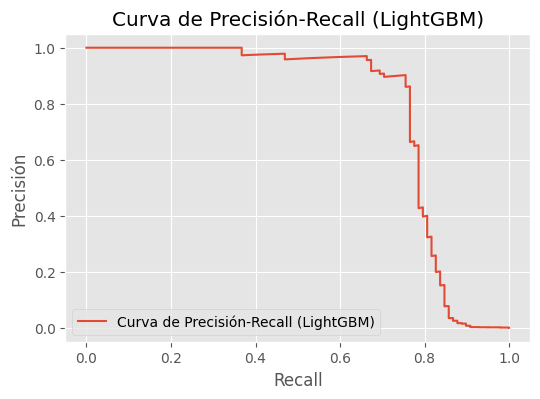

In [11]:
# Extraer los mejores hiperparámetros encontrados
best_params = study.best_params

# Convertir los hiperparámetros a tipos de datos adecuados
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Inicializar el clasificador LightGBM con los mejores hiperparámetros encontrados
clf = LGBMClassifier(**best_params, random_state=48, verbose=-1)

# Entrenar el modelo LightGBM con los datos de entrenamiento
clf.fit(X_train_resampled_scaled, y_train_resampled)

# Realizar predicciones en los datos de prueba
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Calcular el Área Bajo la Curva de Precisión-Recall (AUPRC)
auprc = average_precision_score(y_test, y_pred_proba)
print("Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM:", auprc)

# Calcular la curva de precisión-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Graficar la curva de precisión-recall
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Curva de Precisión-Recall (LightGBM)')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall (LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

### RandomizedSearchCV

In [21]:
# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'learning_rate': uniform(0.001, 0.499),  
    'num_leaves': randint(10, 201),           
    'feature_fraction': uniform(0.0, 1.0),   
    'bagging_fraction': uniform(0.1, 0.9),   
    'max_depth': randint(2, 16),             
    'min_split_gain': uniform(0.001, 0.999), 
    'min_child_weight': uniform(0.5, 19.5),   
    'reg_alpha': uniform(0.0, 1.0),           
    'reg_lambda': uniform(0.0, 1.0),         
    'n_estimators': randint(50, 1001)        
}

# Inicializar el clasificador LightGBM
clf = LGBMClassifier(random_state=43, verbose=-1)

# Inicializar la optimización de hiperparámetros con RandomizedSearchCV
opt = RandomizedSearchCV(
    clf,
    param_dist,
    n_iter=50,
    scoring='average_precision',
    n_jobs=-1,
    cv=5,
    random_state=44,
)

# Realizar la optimización de hiperparámetros
opt.fit(X_train_resampled_scaled, y_train_resampled)

# Obtener los mejores hiperparámetros encontrados
best_params = opt.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

Mejores hiperparámetros encontrados: {'bagging_fraction': 0.7534520367099027, 'feature_fraction': 0.8333662124417559, 'learning_rate': 0.35540511123097906, 'max_depth': 10, 'min_child_weight': 1.681553204633329, 'min_split_gain': 0.08079570450478098, 'n_estimators': 636, 'num_leaves': 106, 'reg_alpha': 0.8217045624293119, 'reg_lambda': 0.9617442003840467}


Área Bajo la Curva de Precisión-Recall (AUPRC): 0.782723048296217


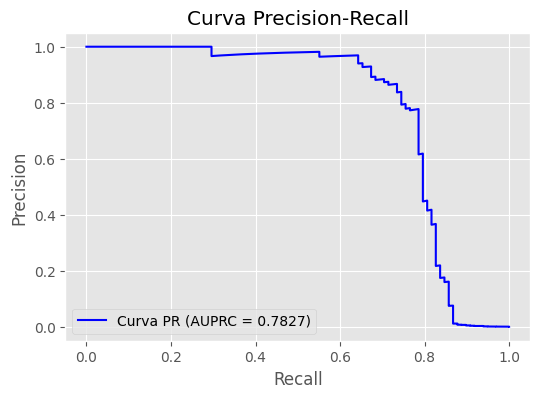

In [23]:
# Inicializar LightGBM con los mejores hiperparámetros encontrados
best_params = opt.best_params_
clf = LGBMClassifier(**best_params, random_state=55, verbose=-1)

# Entrenar el modelo
clf.fit(X_train_resampled_scaled, y_train_resampled)

# Predecir probabilidades de clase positiva en el conjunto de prueba
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Calcular AUPRC
auprc = average_precision_score(y_test, y_pred_proba)
print("Área Bajo la Curva de Precisión-Recall (AUPRC):", auprc)

# Calcular la curva PR
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Trazar la curva PR
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue', label='Curva PR (AUPRC = %0.4f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

En este proyecto, se llevó a cabo un análisis exhaustivo de un conjunto de datos desbalanceado para la detección de fraudes, que incluyó la exploración de características, la selección de variables relevantes y la preparación de datos mediante técnicas de balanceo de clases. Se evaluaron varios algoritmos de clasificación y se optimizaron sus hiperparámetros utilizando diferentes enfoques, como la optimización bayesiana y otros métodos. Finalmente, se seleccionó LightGBM como el modelo final debido a su mejor desempeño, evaluado mediante la métrica AUPRC (Área Bajo la Curva de Precisión-Recall (AUPRC) del modelo LightGBM: 0.7916863626528505). Este enfoque integral permitió obtener un modelo de detección de fraudes con un rendimiento aceptable y resalta la importancia de utilizar estrategias adecuadas para abordar conjuntos de datos desbalanceados en problemas de clasificación.